# **importing the necessary Libraries**

In [24]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import tensorflow as tf
import seaborn as sns
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import layers, models,Sequential,optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report



# **Database Path**

In [25]:
train_dir = '/content/drive/MyDrive/DATASET/Train'
val_dir = '/content/drive/MyDrive/DATASET/Val'
test_dir = '/content/drive/MyDrive/DATASET/Test'
image_size = 224
batch_size = 32
seed=40


# **Split data into training, validation, and testing sets.**

In [50]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(image_size,image_size),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    validation_split=0.2,
    subset="validation",
    shuffle=True,
    seed=seed,
    image_size=(image_size,image_size),
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    validation_split=0.5,
    subset="validation",
    seed=seed,
    image_size=(image_size,image_size),
    batch_size=batch_size
)
class_names = train_ds.class_names
print(class_names)

Found 3000 files belonging to 6 classes.
Using 2400 files for training.
Found 3000 files belonging to 6 classes.
Using 600 files for validation.
Found 3048 files belonging to 6 classes.
Using 1524 files for validation.
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


# Visualize sample images from each class.


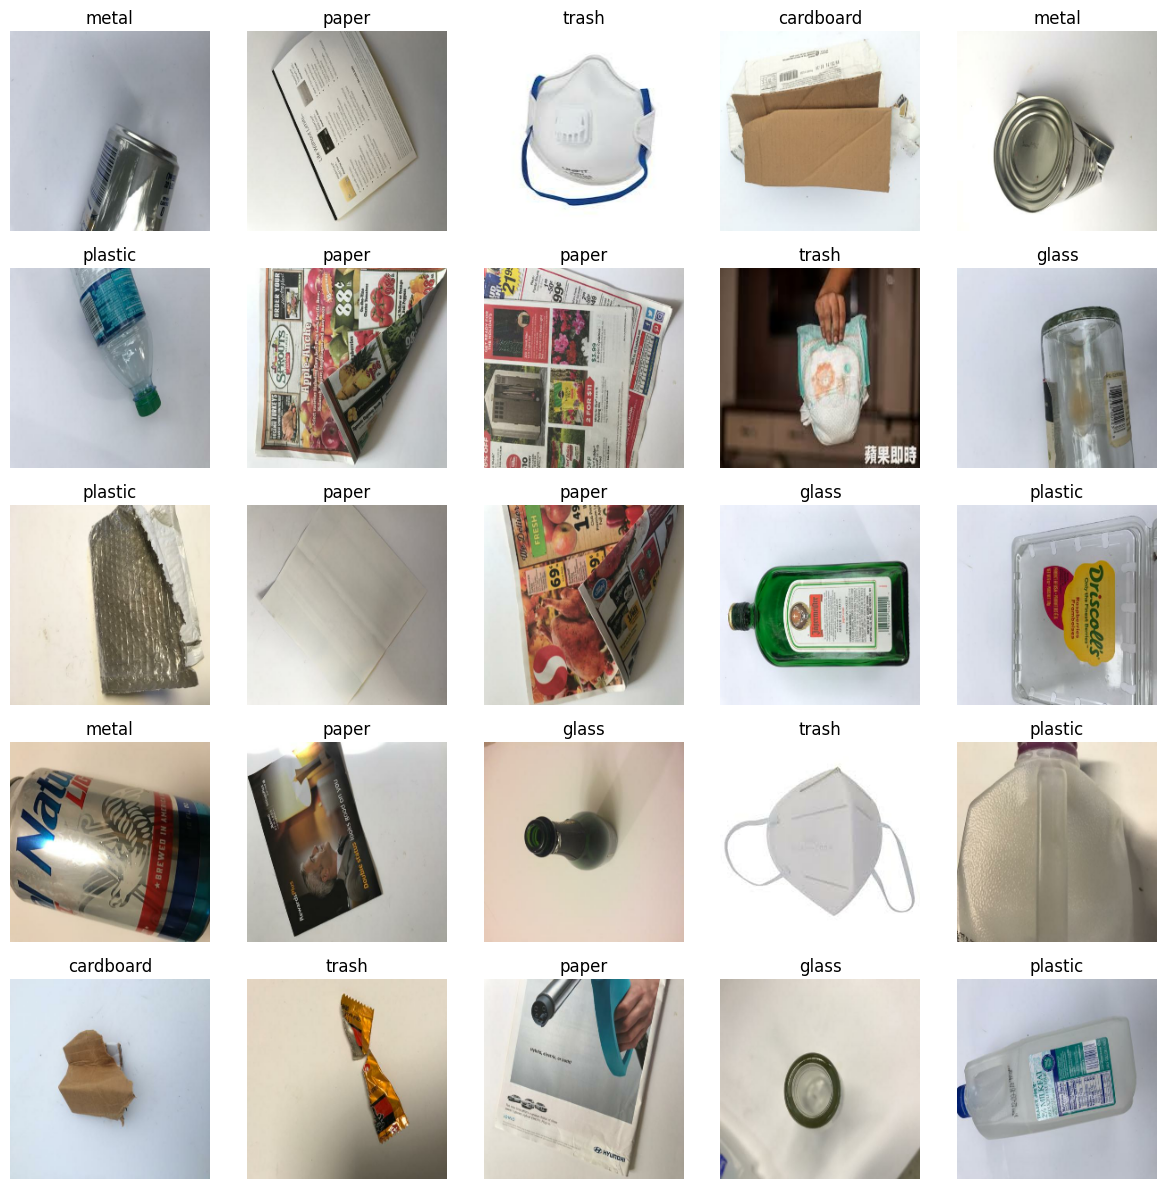

In [27]:
# Extract class names
class_names = train_ds.class_names

# Get one batch of images and labels
images, labels = next(iter(train_ds))

# Plotting first 25 images
plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    # If labels are one-hot encoded, use argmax
    label_index = labels[i].numpy()
    if len(label_index.shape) > 0 and label_index.shape[-1] > 1:
        label_index = np.argmax(label_index)

    plt.title(class_names[label_index])
    plt.axis('off')

plt.tight_layout()
plt.show()


# **Data Preprocessing / Preparation**

In [28]:
data_augmentation = Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# **Check the Number of Images Per Class  Ensure Balance**

Class 'cardboard': 500 images
Class 'glass': 500 images
Class 'metal': 500 images
Class 'paper': 500 images
Class 'plastic': 500 images
Class 'trash': 500 images


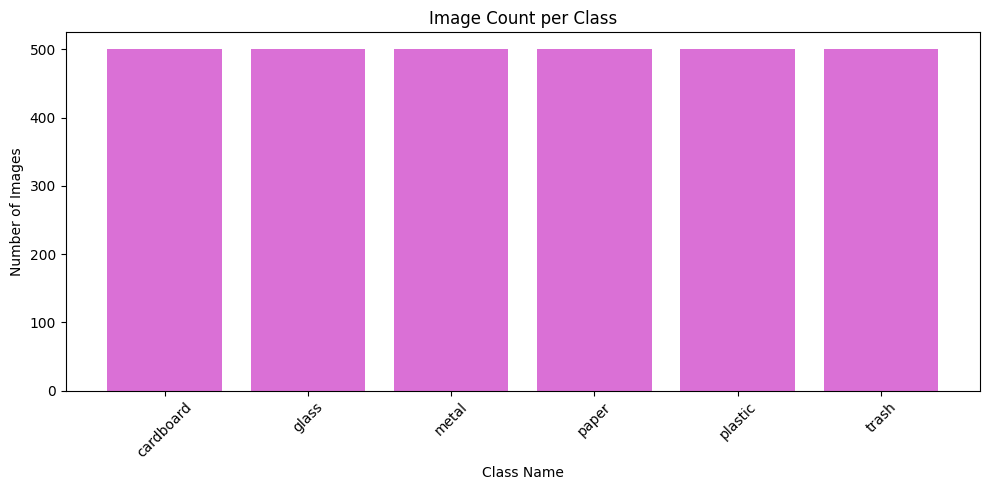

In [29]:
def count_images_per_class(directory):
    class_counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            count = len([
                fname for fname in os.listdir(class_dir)
                if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            class_counts[class_name] = count
    return class_counts

class_counts = count_images_per_class(train_dir)

for cls, count in class_counts.items():
    print(f"Class '{cls}': {count} images")


plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='orchid')
plt.title("Image Count per Class")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Model Selection**


In [30]:
# MobileNetV2 base model
base_model =MobileNetV2(include_top=False, weights='imagenet', input_shape=(image_size,image_size,3))



In [31]:
print(base_model.summary())

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

None


# Adding custom Layers

In [32]:
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(6, activation='softmax')
])

base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze all but last 30 layers
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [33]:
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,526,400 (5.82 MB)

 Non-trainable params: 731,584 (2.79 MB)

None


# Callbacks including saving best model


In [34]:
callbacks = [
    ModelCheckpoint(
        filepath='best_mobilenetv2_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]


# Train the model


In [35]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks,
    batch_size=32

)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4293 - loss: 1.5201
Epoch 1: val_loss improved from inf to 1.75821, saving model to best_mobilenetv2_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 694s 9s/step - accuracy: 0.4313 - loss: 1.5148 - val_accuracy: 0.4617 - val_loss: 1.7582
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7831 - loss: 0.5983
Epoch 2: val_loss improved from 1.75821 to 1.47023, saving model to best_mobilenetv2_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.7833 - loss: 0.5977 - val_accuracy: 0.5550 - val_loss: 1.4702
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8511 - loss: 0.4178
Epoch 3: val_loss improved from 1.47023 to 1.17909, saving model to best_mobilenetv2_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step - accuracy: 0.8513 - loss: 0.4175 - val_accuracy: 0.6433 - val_loss: 1.1791
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8962 - loss: 0.3081
Epoch 4: val_loss improved from 1

# Model Performance Visualization: Accuracy & Loss Trends


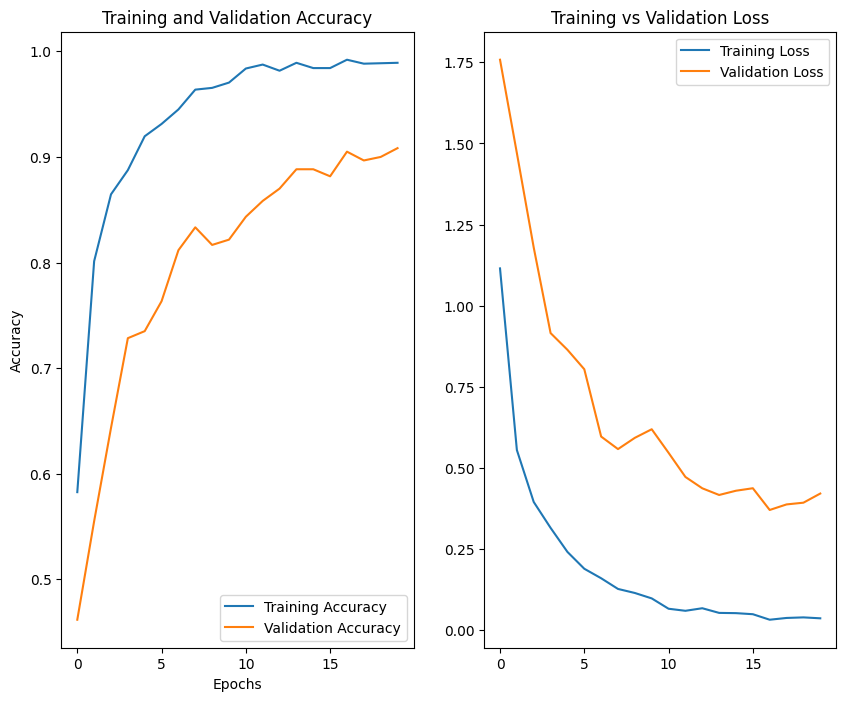

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()


# Model Evaluation

(10,)
tf.Tensor(3, shape=(), dtype=int32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Image 1: True = cardboard | Predicted = cardboard
Image 2: True = paper | Predicted = paper
Image 3: True = metal | Predicted = metal
Image 4: True = paper | Predicted = paper
Image 5: True = cardboard | Predicted = cardboard
Image 6: True = trash | Predicted = trash
Image 7: True = cardboard | Predicted = cardboard
Image 8: True = paper | Predicted = paper
Image 9: True = glass | Predicted = glass
Image 10: True = glass | Predicted = glass


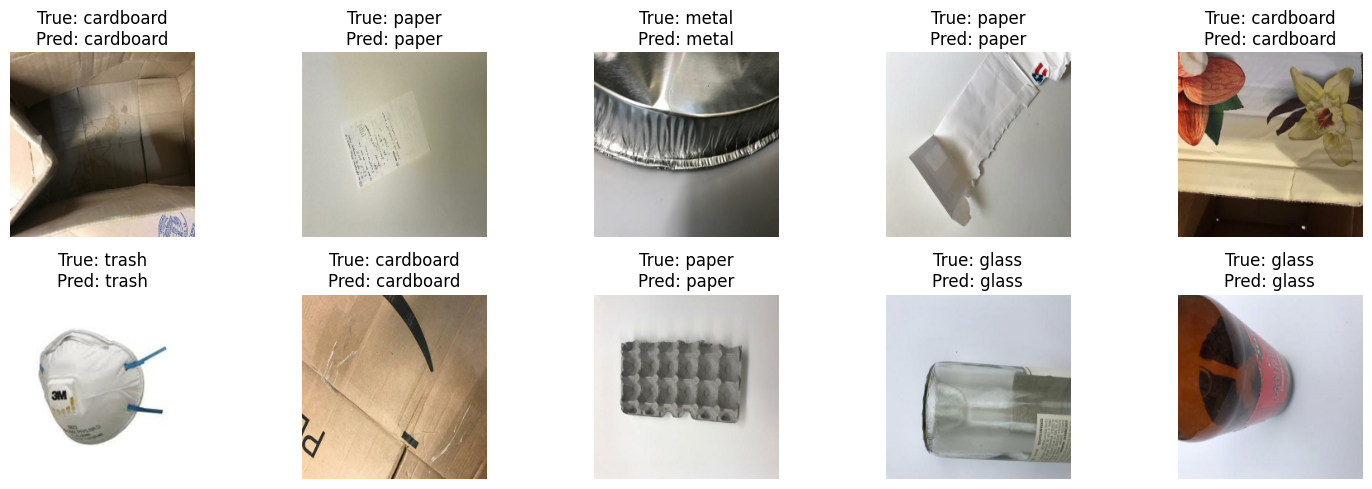

In [74]:
# Get class names
class_names = train_ds.class_names
print(labels.shape)
print(labels[0])

# Get a batch of validation data
images, labels = next(iter(test_ds))

# Limit to 10 images
images = images[:10]
labels = labels[:10]

# Predict
predictions = model.predict(images)

# Convert predictions & true labels to class names
predicted_classes = [class_names[np.argmax(p)] for p in predictions]
true_classes = [class_names[t] for t in labels]
# Print results
for i in range(len(images)):
    print(f"Image {i+1}: True = {true_classes[i]} | Predicted = {predicted_classes[i]}")

# Plot results
plt.figure(figsize=(15,5))
for i in range(len(images)):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis('off')
    plt.title(f"True: {true_classes[i]}\nPred: {predicted_classes[i]}")
plt.tight_layout()
plt.show()


In [38]:
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.9681 - loss: 0.1211
Test accuracy is0.9698, Test loss is 0.1067


In [39]:
# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(val_ds)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class

19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step
[[16 13 17 17 17 14]
 [11 18 14 28 17 17]
 [13 12  8 25 11 16]
 [20 24 19 13 26 13]
 [13 19 19 18 19 16]
 [18 12 12 24 20 11]]
              precision    recall  f1-score   support

           0       0.18      0.17      0.17        94
           1       0.18      0.17      0.18       105
           2       0.09      0.09      0.09        85
           3       0.10      0.11      0.11       115
           4       0.17      0.18      0.18       104
           5       0.13      0.11      0.12        97

    accuracy                           0.14       600
   macro avg       0.14      0.14      0.14       600
weighted avg       0.14      0.14      0.14       600



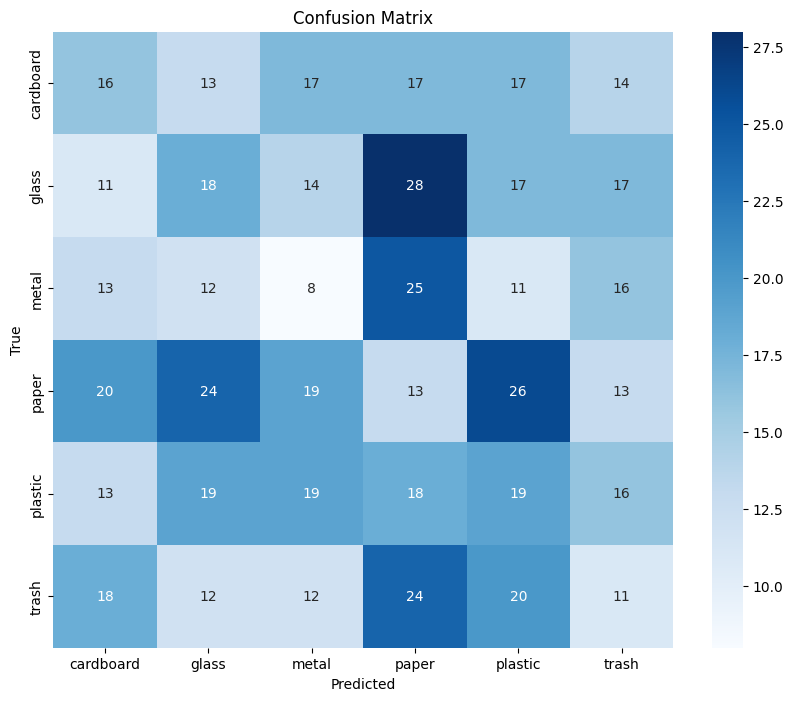

In [40]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

# Final Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


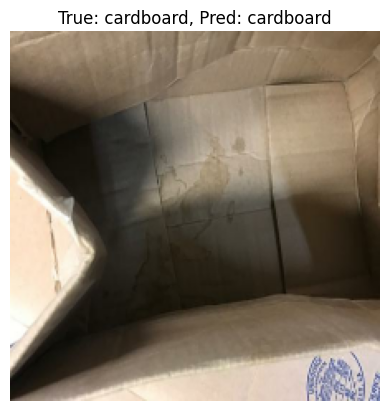

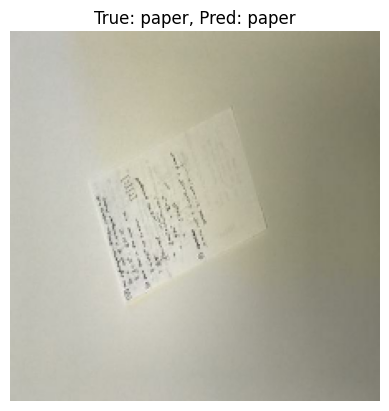

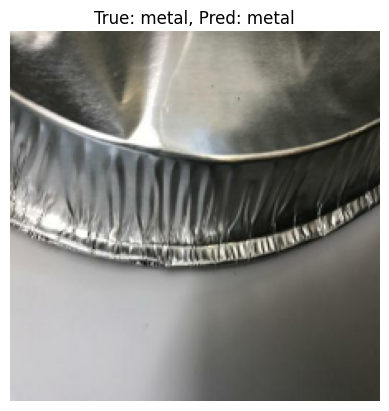

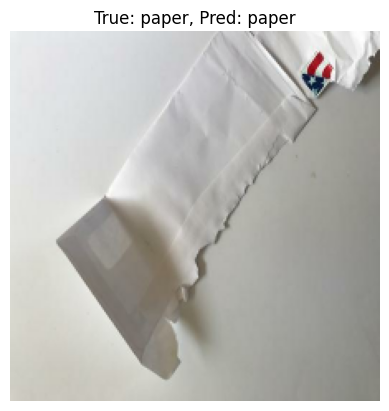

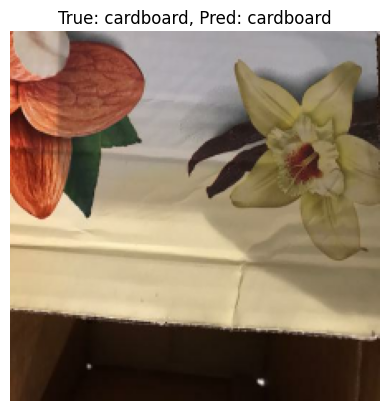

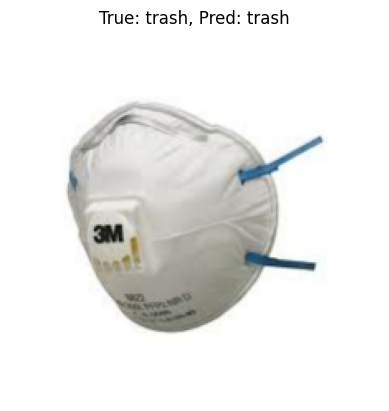

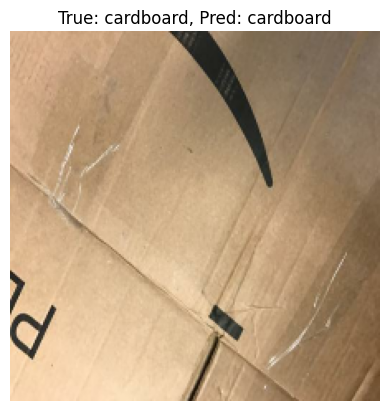

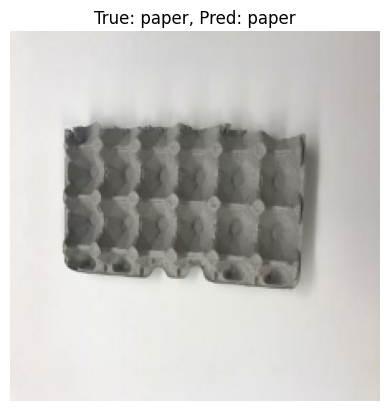

In [41]:
# Get one batch
images, labels = next(iter(test_ds))

# Predict
predictions = model.predict(images)
pred_labels = tf.argmax(predictions, axis=1)

# Loop through first 8 samples
for i in range(8):
    plt.imshow(images[i].numpy().astype("uint8"))  # convert to uint8 if needed
    true_idx = labels[i].numpy() if len(labels.shape) == 1 else tf.argmax(labels[i]).numpy()
    pred_idx = pred_labels[i].numpy()
    plt.title(f"True: {class_names[true_idx]}, Pred: {class_names[pred_idx]}")
    plt.axis("off")
    plt.show()


# Model Deployment

In [42]:
!pip install gradio


In [54]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import gradio as gr

In [82]:
model2=load_model("/content/best_mobilenetv2_model.keras")
def classify_image(img):

    img = img.convert("RGB")
    img = img.resize((224, 224))

    img_tensor = tf.convert_to_tensor(np.array(img), dtype=tf.float32)

    img_tensor = tf.expand_dims(img_tensor, axis=0)

    prediction = model2.predict(img_tensor)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]
    confidence = prediction[0][predicted_class_index]

    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2%})"


iface = gr.Interface(
   fn=classify_image,
    inputs=gr.Image(type="pil", label="Upload Waste Image"),
    outputs=gr.Textbox(label="Prediction"),
    title="♻️ Waste Classifier",
    description="Upload an image of cardboard, plastic, metal, paper, trash, or glass to classify it."
)


# Launch the interface
iface.launch()  # Start the Gradio interface for user interaction

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1a85a0f9dacaeafd35.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
